## Prefect Local Dask Cluster - Example

In [1]:
import dask.dataframe as dd
import pandas as pd
import tempfile
from sklearn.datasets import load_iris
import seaborn as sns

import dask
from dask.distributed import Client
from dask.distributed import get_client
from prefect.executors import DaskExecutor
from prefect import Flow, task

from dask.diagnostics import ProgressBar
import dask.array as da
import os

import skimage
from skimage import data, io, filters
import glob
import shutil
import sys
from devtools import debug

### Make Graphviz available

Get the path of your current environment

In [2]:
os.environ['PATH'] = f"/home/user2135/.conda/envs/datascience/bin/:{os.environ['PATH']}"

In [3]:
shutil.which('dot')

'/home/user2135/.conda/envs/datascience/bin/dot'

In [4]:
pbar = ProgressBar()                
pbar.register() # global registration

In [5]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 7.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39365,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 7.71 GiB
Comm: tcp://127.0.0.1:34241,Total threads: 1
Dashboard: http://127.0.0.1:33073/status,Memory: 7.71 GiB
Nanny: tcp://127.0.0.1:37611,


In [6]:
client.dashboard_link

'http://127.0.0.1:8787/status'

### Access the Local Dask Cluster Dashboard

From the Client widget grab the dashboard port. You'll need to proxy it as:

**your-jhub-address/user/{YOUR_USER}/proxy/{DASHBOARD_PORT}/status**

In [7]:
executor = DaskExecutor(address=client.scheduler.address)
executor

<Executor: DaskExecutor>

In [8]:
# Loading built-in Datasets:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [9]:
iris_dd = dd.from_pandas(iris, npartitions=1)
iris_dd

,sepal_length,sepal_width,petal_length,petal_width,species
npartitions=1,,,,,
0,float64,float64,float64,float64,object
149,...,...,...,...,...


In [10]:
#! wget https://cellprofiler-examples.s3.amazonaws.com/ExampleHuman.zip
#! unzip ExampleHuman.zip

In [11]:
tifs = glob.glob('ExampleHuman/images/*.tif')
tifs

['ExampleHuman/images/AS_09125_050116030001_D03f00d1.tif',
 'ExampleHuman/images/AS_09125_050116030001_D03f00d0.tif',
 'ExampleHuman/images/AS_09125_050116030001_D03f00d2.tif']

In [12]:
image = skimage.io.imread(tifs[0])
image

array([[10, 10, 10, ..., 11,  9,  9],
       [11, 11,  9, ..., 10,  9, 10],
       [10,  9, 11, ..., 10,  9, 10],
       ...,
       [ 9,  9,  9, ...,  9,  9,  9],
       [ 9,  9, 10, ..., 10,  9,  9],
       [10, 10,  9, ...,  8,  9, 10]], dtype=uint8)

In [13]:
da.from_array(image)

dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>

### Create a Prefect Flow

Let's make a prefect flow, run it, visualize it in prefect, and then also visualize it in the dask status board.

*There is absolutely no reason why you would run this particular flow. It's here for demonstration purposes.*

In [14]:
@task
def get_mean_per_row(image):
    return image.mean(axis=1).compute()[0]

@task
def get_max_per_row(image):
    return image.max(axis=1).compute()[0]
    
@task
def get_min_per_row(image):
    return image.min(axis=1).compute()[0]

@task
def convert_to_dask_array(image):
    return da.from_array(image)

@task
def read_images(image_file):
    return skimage.io.imread(image_file)

with Flow('read_images_flow') as flow:
    images = read_images.map(image_file=tifs)
    images_da = convert_to_dask_array.map(image=images)
    images_min = get_min_per_row.map(image=images_da)
    images_max = get_max_per_row.map(image=images_da)
    images_mean = get_mean_per_row.map(image=images_da)

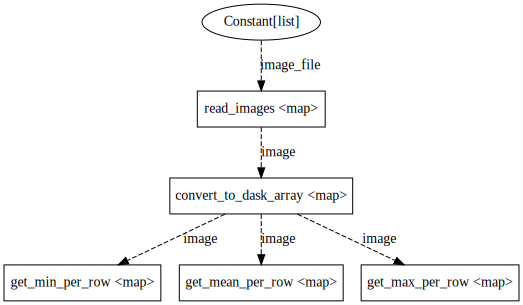

In [15]:
flow.visualize()

In [16]:
flow_state = flow.run(executor=executor)
flow_state

[2022-06-23 23:41:23+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'read_images_flow'
[2022-06-23 23:41:23+0000] INFO - prefect.DaskExecutor | Connecting to an existing Dask cluster at tcp://127.0.0.1:39365


/home/user2135/.conda/envs/datascience/lib/python3.8/site-packages/distributed/scheduler.py:4823: UserWarning: Scheduler already contains a plugin with name worker-status; overwriting.
  warnings.warn(


[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images': Starting task run...
[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images': Finished task run for task with final state: 'Mapped'
[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images[0]': Starting task run...
[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images[0]': Finished task run for task with final state: 'Success'
[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images[1]': Starting task run...
[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images[1]': Finished task run for task with final state: 'Success'
[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images[2]': Starting task run...
[2022-06-23 23:41:28+0000] INFO - prefect.TaskRunner | Task 'read_images[2]': Finished task run for task with final state: 'Success'
[2022-06-23 23:41:29+0000] INFO - prefect.TaskRunner | Task 'convert_to_dask_ar

/home/user2135/.conda/envs/datascience/lib/python3.8/site-packages/prefect/executors/dask.py:313: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  scheduler_comm.close_rpc()


<Success: "All reference tasks succeeded.">

### Getting the Prefect Results

If you run your functions in a prefect flow you need to interact with the `flow_state` object in order to get your results.

[Interacting with Results](https://docs.prefect.io/core/concepts/results.html#interacting-with-task-result-objects)

### Getting the Prefect Results for objects in memory

If you are calling prefect from a notebook or script it is likely that your objects are still in memory. You can reference the results by use the `flow_state.result[my_object]`.

In [17]:
images_da.result

In [18]:
flow_state.result

{<Task: Constant[list]>: <Success>,
 <Task: get_min_per_row>: <Mapped: "Ready to proceed with mapping.">,
 <Task: get_mean_per_row>: <Mapped: "Ready to proceed with mapping.">,
 <Task: read_images>: <Mapped: "Ready to proceed with mapping.">,
 <Task: get_max_per_row>: <Mapped: "Ready to proceed with mapping.">,
 <Task: convert_to_dask_array>: <Mapped: "Ready to proceed with mapping.">}

In [19]:
flow_state.result[images_da]._result

<Result: [dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>, dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>, dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>]>

In [20]:
help(flow_state.result[images_da]._result)

Help on Result in module prefect.engine.result.base object:

class Result(builtins.object)
 |  Result(value: Any = None, location: str = None, serializer: prefect.engine.serializers.Serializer = None)
 |  
 |  A representation of the result of a Prefect task; this class contains
 |  information about the value of a task's result, a result handler specifying
 |  how to serialize or store this value securely, and a `safe_value` attribute
 |  which holds information about the current "safe" representation of this
 |  result.
 |  
 |  Args:
 |      - value (Any, optional): the value of the result
 |      - location (Union[str, Callable], optional): Possibly templated location
 |          to be used for saving the result to the destination. If a callable
 |          function is provided, it should have signature `callable(**kwargs) ->
 |          str` and at write time all formatting kwargs will be passed and a fully
 |          formatted location is expected as the return value.  Can be us

In [21]:
flow_state.result[images_da]._result.value

[dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>,
 dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>,
 dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>]

### Getting Results from Prefect Flow State

If your objects are no longer in memory you will need to do a bit more digging.

*Note* You probably don't really want to be doing this, but instead persisting your results to a database/parquet file/etc.

In [22]:
flow_state.result.keys()

dict_keys([<Task: Constant[list]>, <Task: get_min_per_row>, <Task: get_mean_per_row>, <Task: read_images>, <Task: get_max_per_row>, <Task: convert_to_dask_array>])

In [23]:
results = {}
for key in flow_state.result.keys():
    print(key)
    results[str(key)] = flow_state.result[key]._result
    
results.keys()

<Task: Constant[list]>
<Task: get_min_per_row>
<Task: get_mean_per_row>
<Task: read_images>
<Task: get_max_per_row>
<Task: convert_to_dask_array>


dict_keys(['<Task: Constant[list]>', '<Task: get_min_per_row>', '<Task: get_mean_per_row>', '<Task: read_images>', '<Task: get_max_per_row>', '<Task: convert_to_dask_array>'])

In [24]:
results['<Task: get_max_per_row>']

<Result: [12, 82, 178]>